# Setup

In [1]:
! pip install transformers newspaper3k

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.1 MB/s 
     |████████████████████████████████| 211 kB 56.1 MB/s 
     |████████████████████████████████| 7.6 MB 60.5 MB/s 
     |████████████████████████████████| 182 kB 56.4 MB/s 
     |████████████████████████████████| 7.4 MB 38.4 MB/s 
     |████████████████████████████████| 81 kB 8.3 MB/s 
     |████████████████████████████████| 93 kB 2.5 MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13552 sha256=1fa91e0ea3d5efaf55d1c5a95769fba704ff72175f3448eff4fdc115d575bf02
  Stored in directory: /root/.cache/pip/wheels/99/74/83/8fac1c8d9c648cfabebbbffe97a889f6624817f3aa0bbe6c09
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3354 sha256=079c410281ea96362ceedcca0e4fe3af10b1d7d55550d715b4fe7720b9abf5fb
  Stored in directory: /root/.cache/pip/wheels/b6/09/68/a9f15498ac02c23d

In [2]:
# ! python -m spacy download en_core_web_sm

In [3]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from newspaper import Article
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from transformers import pipeline
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
MAIN_FOLDER = '/content/drive/MyDrive/url_classification/'
HTML_FOLDER = MAIN_FOLDER + 'html_files_Nov-24-2022/'
os.chdir(MAIN_FOLDER)

In [6]:
TARGET = 'label'
TEXT = 'text'
STOPWORDS = set(stopwords.words('english'))

# Defining functions get_data and preprocessing:

In [7]:
def get_html_files(html_folder=HTML_FOLDER):
  html_files = os.listdir(html_folder)
  return html_files

In [8]:
def create_df(csv_path, usecols):
  df = pd.read_csv(csv_path, usecols = usecols)
  df.rename(columns={usecols[0]: 'filename', usecols[1]: 'label'}, inplace=True)
  df = df[~df['filename'].isna()]
  print(f'Original shape: {df.shape}')
  df = df[df['label'] != '-']
  df.reset_index(drop=True, inplace=True)
  print(f'Final shape: {df.shape}')
  return df

In [9]:
def get_target_distribution(df, normalize=False):
  return df[TARGET].value_counts(normalize=normalize)

In [10]:
def read_htmls(df):
  current_filenames = df['filename'].values
  htmls = list()

  for i, filename in enumerate(current_filenames):
    try:
      with open(f'{HTML_FOLDER}{filename}') as f:
        html = f.read()
        htmls.append(html)
    except FileNotFoundError:
      print(f'File {i} not found: "{filename}"')
  
  return htmls

In [11]:
def read_articles(htmls):
  toi_articles = list()

  for html in htmls:
    toi_article = Article(url = ' ', language="en")
    toi_article.set_html(html)
    toi_article.parse()
    toi_article.nlp()
    toi_articles.append(toi_article)

  return toi_articles

In [12]:
def create_y(df):
  return df[TARGET].tolist()

In [13]:
def create_summary(toi_articles):
  title_and_summary = [(toi_article.title + '. ' + toi_article.summary).replace('\n', ' ') for toi_article in toi_articles]
  return title_and_summary

In [45]:
def create_df_text(text, y, minimum_words, maximum_classes):
  df_text = pd.DataFrame({TEXT: title_and_summary, TARGET: y})
  # df_text[TEXT] = df_text.loc[:, TEXT].str.lower()

  if minimum_words:
    df_text = df_text[df_text[TEXT].str.split().str.len() > minimum_words]

  if maximum_classes:
    relevant_labels = df_text[TARGET].value_counts()[:maximum_classes].index
    df_text = df_text[df_text[TARGET].isin(relevant_labels)]
    
  df_text.reset_index(drop=True, inplace=True)

  return df_text

In [15]:
def split_X_y(df, test_size, random_state):
  X = df.drop(TARGET, axis=1)
  y = df[TARGET]

  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size=test_size,
                                                      stratify=y, 
                                                      random_state=random_state)
  return X_train, X_test, y_train, y_test

In [16]:
def get_baseline_accuracy(y_train, y_test):
  majority_class = y_train.value_counts().index[0]
  baseline_accuracy = sum(y_test == majority_class) / len(y_test)
  return baseline_accuracy

In [17]:
def get_most_common_tokens(X_train, amount=10):
  tokenized = [word_tokenize(string) for string in X_train[TEXT]]
  flat_list = [item for sublist in tokenized for item in sublist]
  return Counter(flat_list).most_common(amount)

In [18]:
def load_nlp():
  nlp = spacy.load('en_core_web_sm')
  return nlp

In [19]:
def lemmatize_text(X_train, nlp):
  lemmatized_text = list()
  for text in X_train[TEXT]:
    lemmas = [token.lemma_.lower() for token in nlp(text)]
    lemmatized_text.append(lemmas)

  return lemmatized_text

In [20]:
def fit_transform_articles(X_train, X_test, vectorizer, stop_words):
  vectorizers = {'count': CountVectorizer(stop_words=stop_words), 'tfidf': TfidfVectorizer(stop_words=stop_words)}

  try:
    vectorizer = vectorizers[vectorizer]
  except KeyError:
    raise KeyError("vectorizer should be either 'count' or 'tfidf'")

  X_train_transformed = vectorizer.fit_transform(X_train[TEXT])
  X_test_transformed = vectorizer.transform(X_test[TEXT])

  return X_train_transformed, X_test_transformed, vectorizer

In [21]:
def get_data(csv_path='url_classification_temporary.csv', usecols=['File Name', 'Label']):
  # html_files = get_html_files() # NOT USING IT, NECESSARY? DON'T THINK SO, BUT CHECK
  df = create_df(csv_path, usecols)
  # get_target_distribution(df, normalize=True)
  htmls = read_htmls(df)
  toi_articles = read_articles(htmls)
  y = create_y(df)
  assert len(toi_articles) == len(y)
  title_and_summary = create_summary(toi_articles)

  return y, title_and_summary

def preprocessing(y, title_and_summary, maximum_classes=4, minimum_words=30, test_size=0.2, random_state=None, vectorizer='count', stop_words=None):
  df_text = create_df_text(title_and_summary, y, minimum_words, maximum_classes)
  X_train, X_test, y_train, y_test = split_X_y(df_text, test_size, random_state)
  # get_baseline_accuracy(y_train, y_test)
  # get_most_common_tokens(amount=5)
  nlp = load_nlp() # NOT USING IT, NECESSARY? DON'T THINK SO, BUT CHECK
  # lemmatized_text = lemmatize_text(X_train, nlp) # NOT USING IT, NECESSARY? DON'T THINK SO, BUT CHECK
  X_train_transformed, X_test_transformed, vectorizer = fit_transform_articles(X_train, X_test, vectorizer, stop_words) # to see output: X_train.toarray() or X_test.toarray()


  return X_train_transformed, X_test_transformed, y_train, y_test, vectorizer

# Defining functions for modeling:

In [22]:
def fit_model(clf, X_train_transformed, y_train):
  clf.fit(X_train_transformed, y_train)
  return clf

In [23]:
def predict(clf, X_test_transformed):
  y_pred = clf.predict(X_test_transformed)
  return y_pred

In [24]:
def get_accuracy(y_test, y_pred):
  accuracy = sum(y_pred == y_test) / len(y_test)
  return accuracy

In [25]:
def print_important_features(clf, features=5):
  """ 
  Get the most important features of a classifier when using a linear kernel (e.g. Logistic Regression, not SVM)
  """
  coef_importances = np.argsort(clf.coef_, axis=1)
  for i, class_ in enumerate(coef_importances[:, :features]):
      print(f'Class "{clf.classes_[i]}" - {features} most important features: '
            f'{vectorizer.get_feature_names_out()[class_]}')

In [26]:
def print_confusion_matrix(y_test, y_pred):
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.title(f'Confusion matrix - acc {get_accuracy(y_test, y_pred):.3f}', size=15)
  plt.show()

# Executing functions get_data and preprocessing:

In [28]:
y, title_and_summary = get_data(csv_path='url_classification_temporary5.csv')

Original shape: (294, 2)
Final shape: (236, 2)


In [92]:
df_text = create_df_text(title_and_summary, y, minimum_words=30, maximum_classes=4)

In [93]:
df_text

,text,label
0,Write For Us. We allow you an endless opportun...,MISC
1,Write for Us. If you’ve got an idea that will ...,MISC
2,FAQs for some new features available in the Be...,Blog
3,The Web Credibility Project. Our research in W...,Home Page
4,Model DJs for Retail. DJPeoples is the nation’...,MISC
...,...,...
178,Write for us and get noticed by top developers...,MISC
179,Coming Soon & Maintenance Mode for WordPress. ...,Blog
180,The Retail and Ecommerce Conference for Market...,Home Page
181,Content Strategy for Enterprise Marketers. Con...,Home Page


In [94]:
print(f"Amount of words before cleaning text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")

Amount of words before cleaning text: 18052


In [95]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text

    # nlp = load_nlp()
    # text = ' '.join(token.lemma_ for token in nlp(text))

    return text

In [96]:
df_text[TEXT] = df_text[TEXT].apply(clean_text)

In [97]:
df_text

,text,label
0,write us allow endless opportunity new authors...,MISC
1,write us youve got idea challenge readers move...,MISC
2,faqs new features available beta wayback machi...,Blog
3,web credibility project research web credibili...,Home Page
4,model djs retail djpeoples nations premier age...,MISC
...,...,...
178,write us get noticed top developers clients wr...,MISC
179,coming soon maintenance mode wordpress answere...,Blog
180,retail ecommerce conference marketers speakers...,Home Page
181,content strategy enterprise marketers content ...,Home Page


In [98]:
print(f"Amount of words after cleaning text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")

Amount of words after cleaning text: 11151


In [99]:
X_train, X_test, y_train, y_test = split_X_y(df_text, test_size=0.2, random_state=0)
# get_baseline_accuracy(y_train, y_test)
# get_most_common_tokens(amount=5)
# nlp = load_nlp() # NOT USING IT, NECESSARY? DON'T THINK SO, BUT CHECK
# lemmatized_text = lemmatize_text(X_train, nlp) # NOT USING IT, NECESSARY? DON'T THINK SO, BUT CHECK

In [100]:
X_train_transformed, X_test_transformed, vectorizer = fit_transform_articles(X_train, X_test, vectorizer='tfidf', stop_words=None)

In [105]:
X_train_transformed.shape, X_test_transformed.shape, y_train.shape, y_test.shape

((146, 3054), (37, 3054), (146,), (37,))

# Executing functions for modeling:

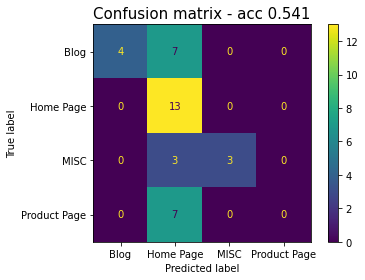

In [106]:
clf = fit_model(LogisticRegression(max_iter=3000, 
                                   random_state=0), 
                X_train_transformed, 
                y_train)

y_pred = predict(clf, X_test_transformed)

# print_important_features(clf, features=5)

print_confusion_matrix(y_test, y_pred)

In [107]:
# print_confusion_matrix(y_test, y_pred) # 3rd version

In [108]:
# print_confusion_matrix(y_test, y_pred) # 4th version

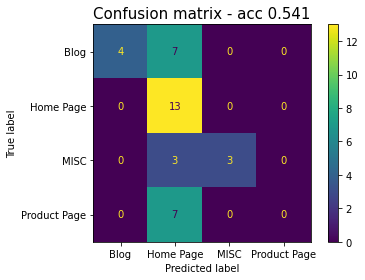

In [109]:
print_confusion_matrix(y_test, y_pred) # 5th version

#### Trying SVM

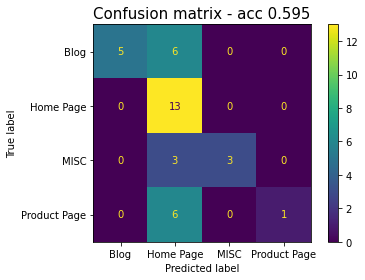

In [110]:
clf = fit_model(SVC(C=1.0,
                    class_weight='balanced', 
                    random_state=0), 
                X_train_transformed, 
                y_train)

y_pred = predict(clf, X_test_transformed)

print_confusion_matrix(y_test, y_pred) # 4th version

#### Trying KNN 5

In [36]:
# # without stop words
# clf = fit_model(KNeighborsClassifier(n_neighbors=5), 
#                 X_train_transformed, 
#                 y_train)

# y_pred = predict(clf, X_test_transformed)

# print_confusion_matrix(y_test, y_pred)

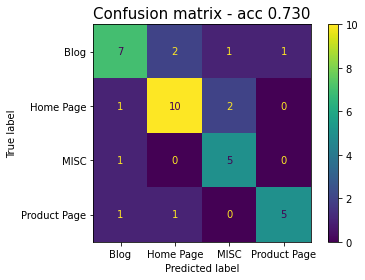

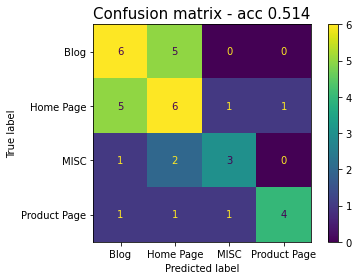

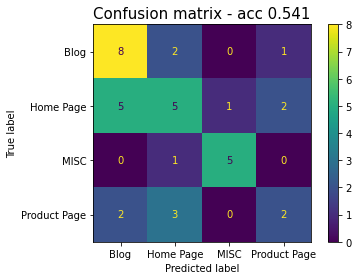

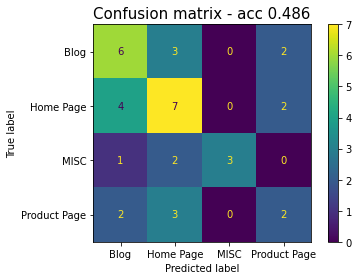

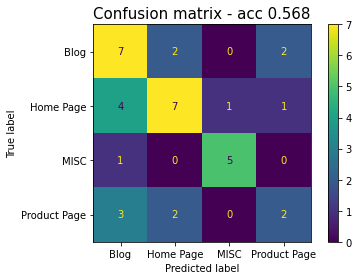

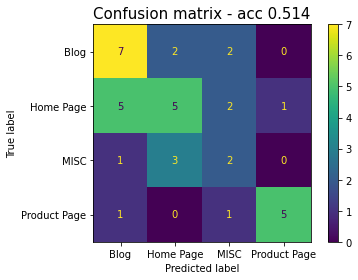

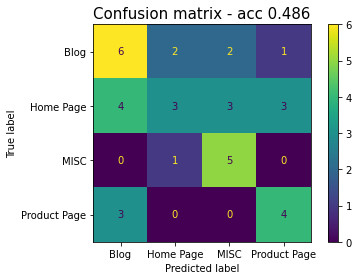

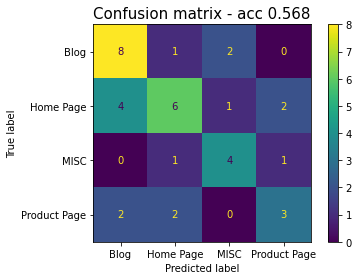

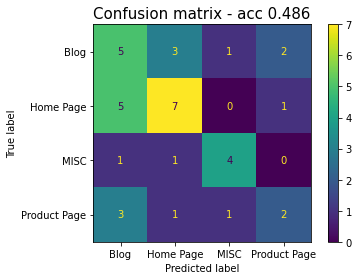

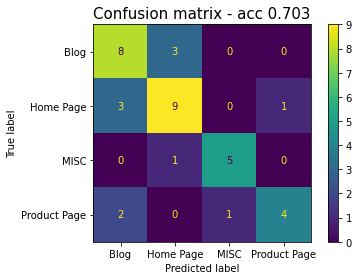

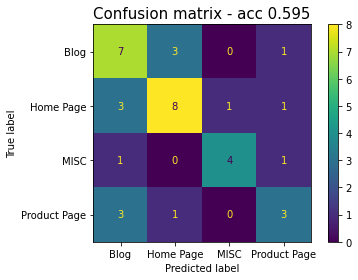

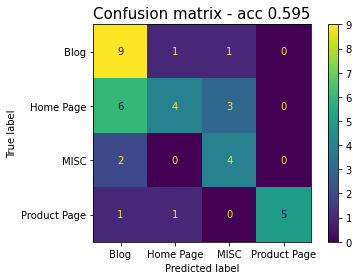

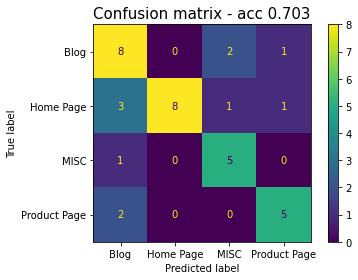

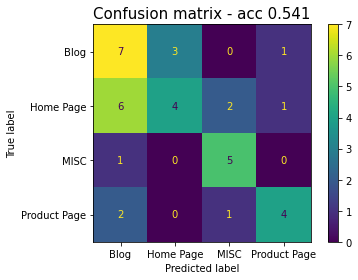

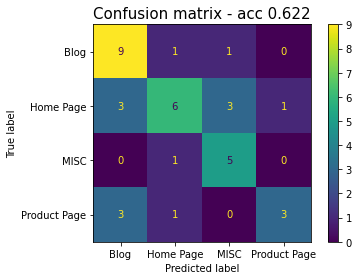

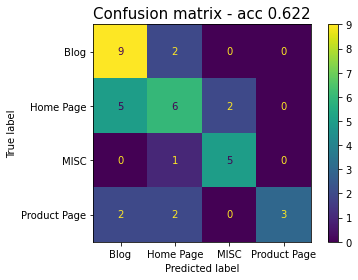

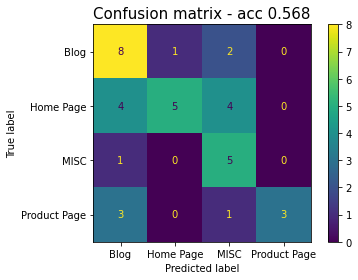

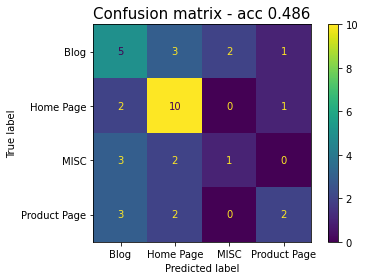

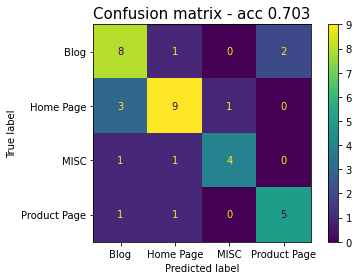

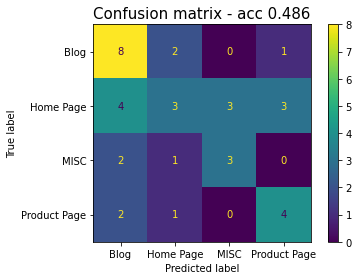

In [111]:
# with stop words from NLTK
# playing with different random states:
for i in range(20):
  X_train_transformed, X_test_transformed, y_train, y_test, vectorizer = preprocessing(y, title_and_summary, maximum_classes=4, 
                                                                                      test_size=0.2, random_state=i, vectorizer='tfidf', stop_words=STOPWORDS)

  clf = fit_model(KNeighborsClassifier(n_neighbors=5), 
                  X_train_transformed, 
                  y_train)

  y_pred = predict(clf, X_test_transformed)

  print_confusion_matrix(y_test, y_pred)

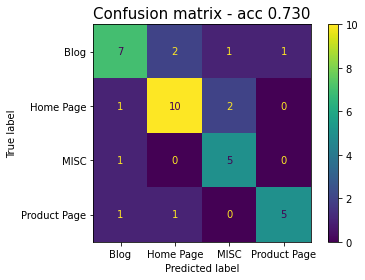

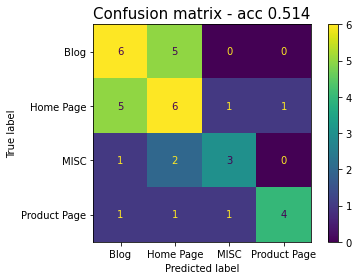

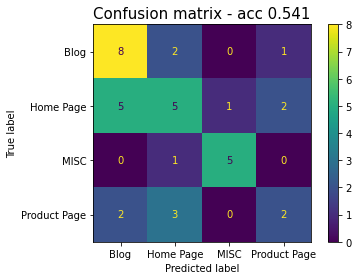

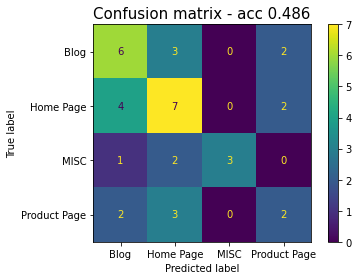

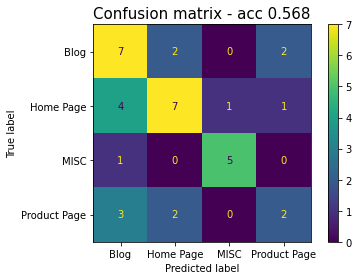

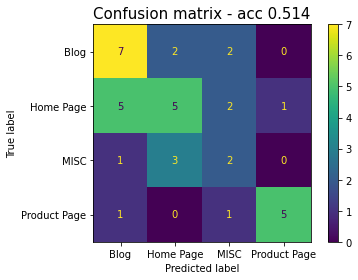

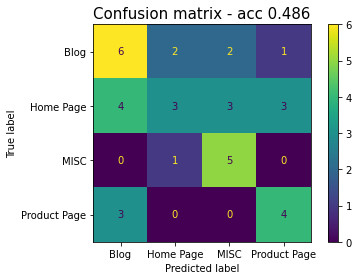

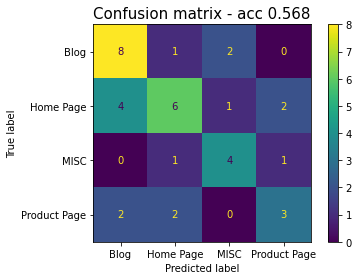

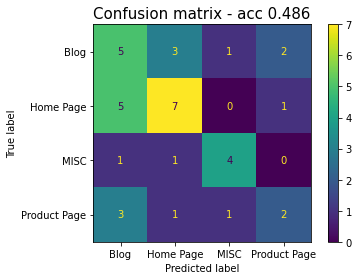

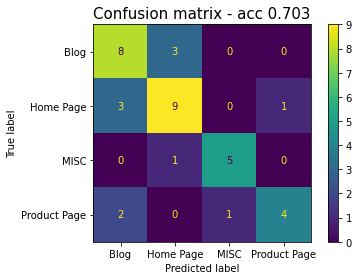

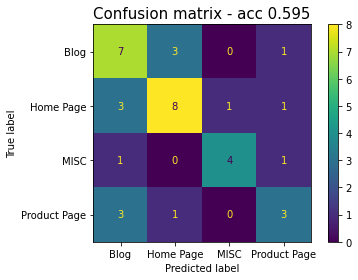

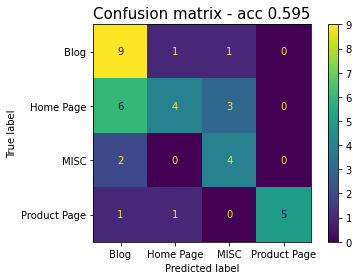

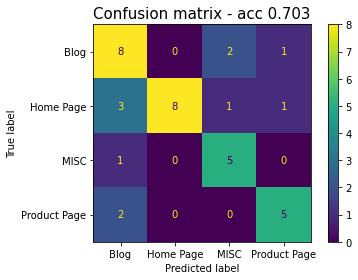

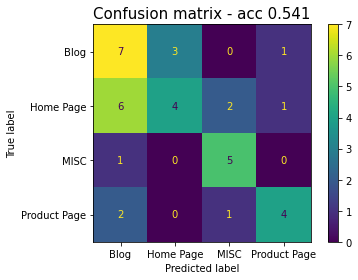

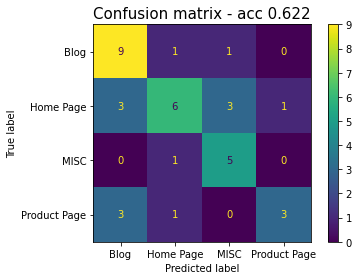

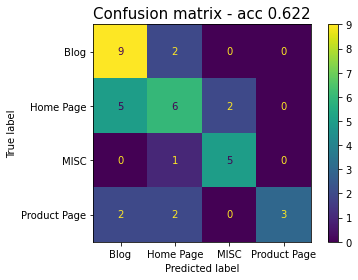

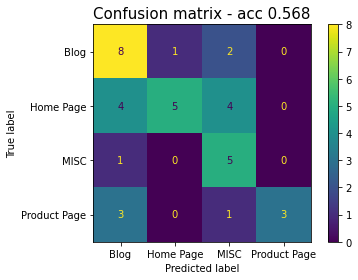

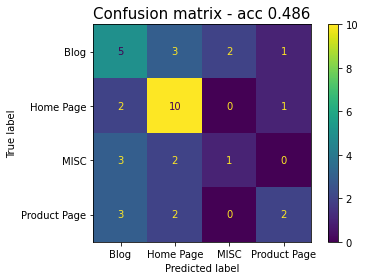

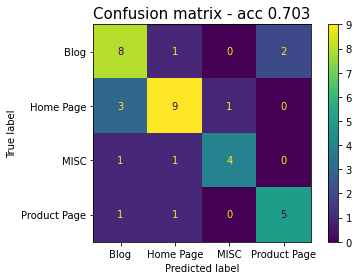

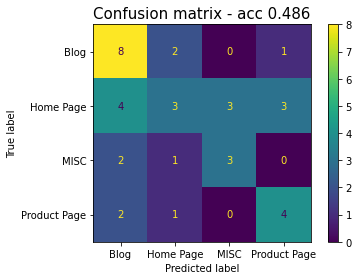

In [42]:
# with stop words from NLTK
# playing with different random states:
for i in range(20):
  X_train_transformed, X_test_transformed, y_train, y_test, vectorizer = preprocessing(y, title_and_summary, maximum_classes=4, 
                                                                                      test_size=0.2, random_state=i, vectorizer='tfidf', stop_words=STOPWORDS)

  clf = fit_model(KNeighborsClassifier(n_neighbors=5), 
                  X_train_transformed, 
                  y_train)

  y_pred = predict(clf, X_test_transformed)

  print_confusion_matrix(y_test, y_pred)

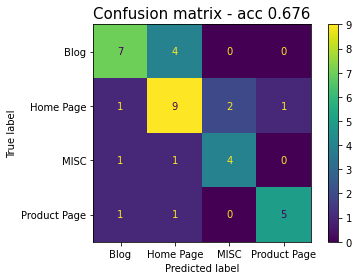

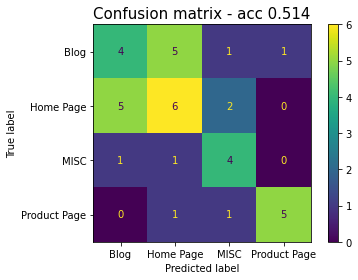

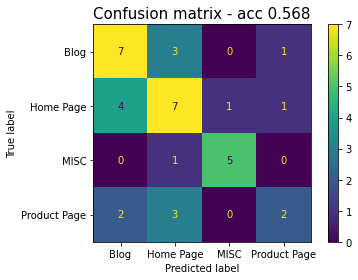

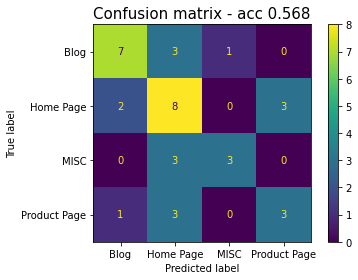

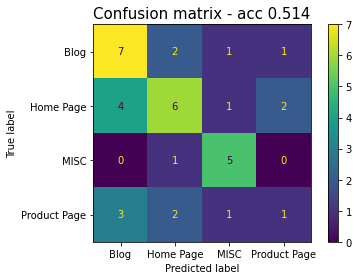

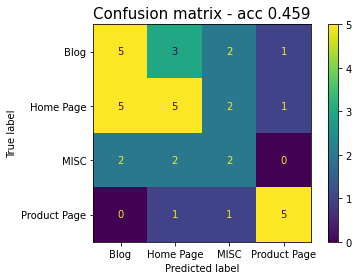

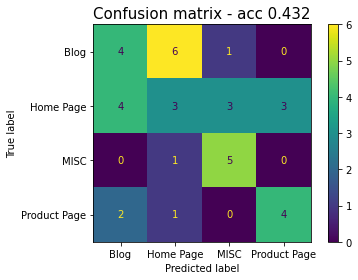

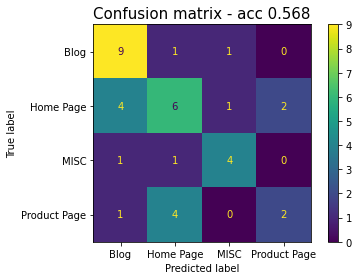

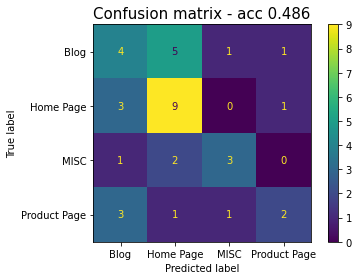

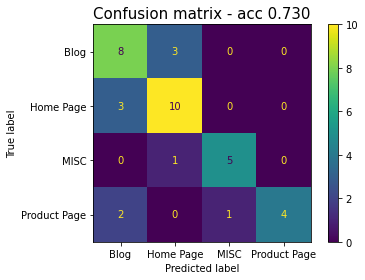

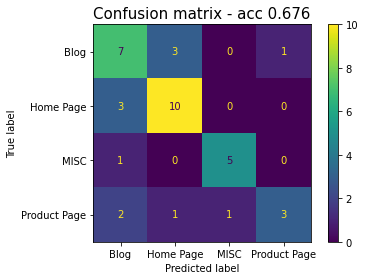

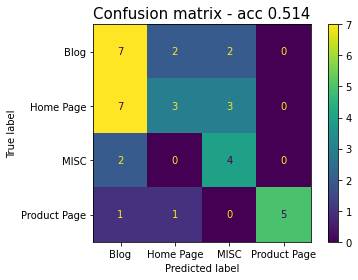

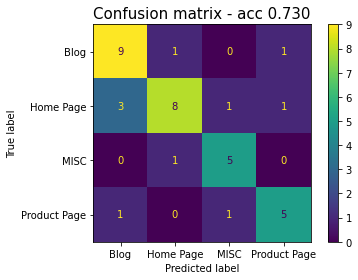

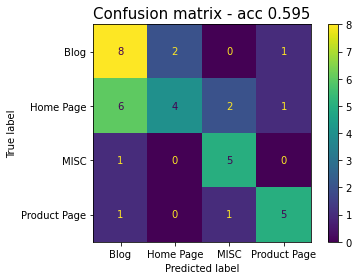

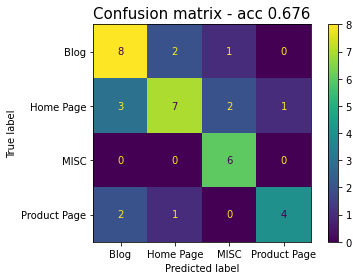

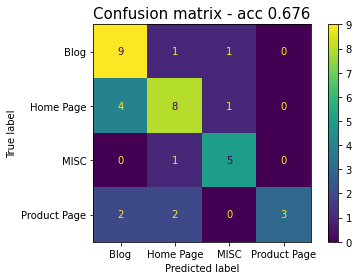

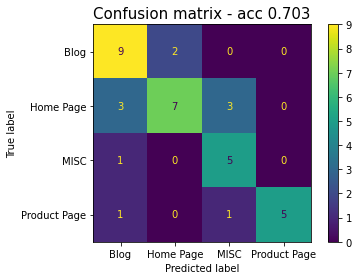

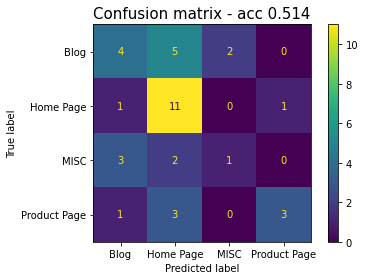

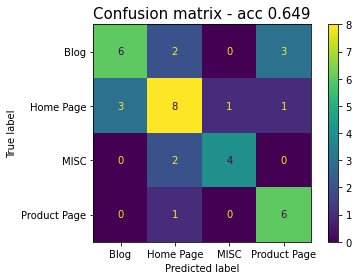

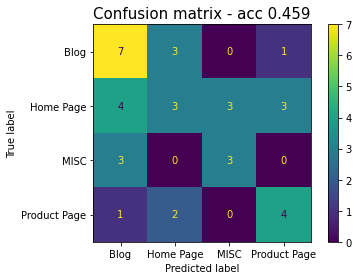

In [112]:
# with stop words from NLTK
# playing with different random states:
for i in range(20):
  X_train_transformed, X_test_transformed, y_train, y_test, vectorizer = preprocessing(y, title_and_summary, maximum_classes=4, 
                                                                                      test_size=0.2, random_state=i, vectorizer='tfidf', stop_words=STOPWORDS)

  clf = fit_model(KNeighborsClassifier(n_neighbors=6), 
                  X_train_transformed, 
                  y_train)

  y_pred = predict(clf, X_test_transformed)

  print_confusion_matrix(y_test, y_pred)

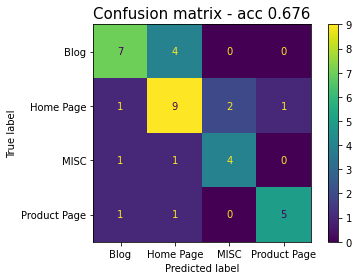

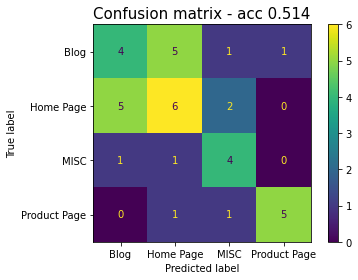

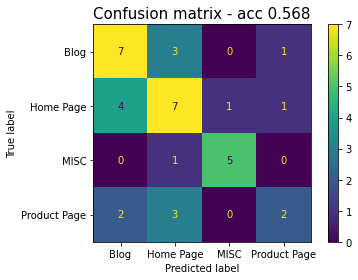

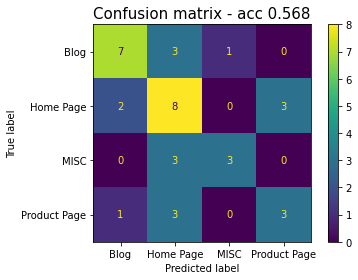

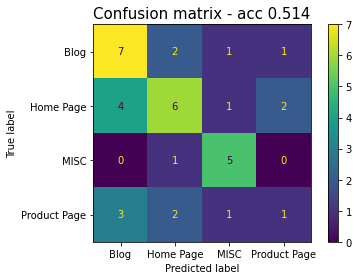

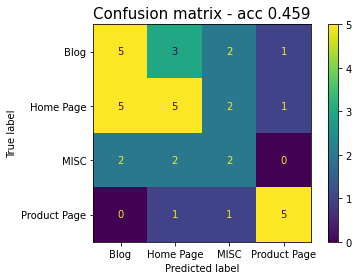

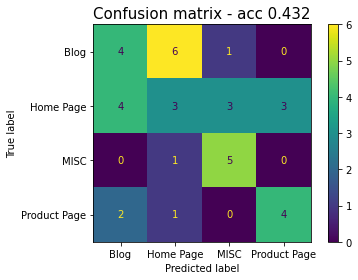

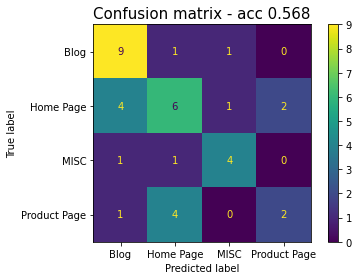

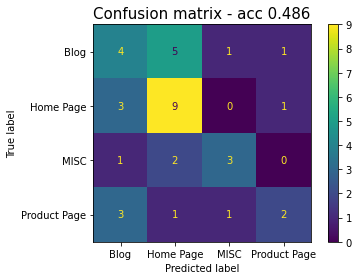

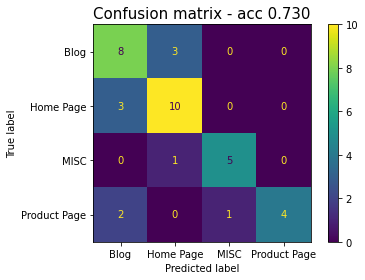

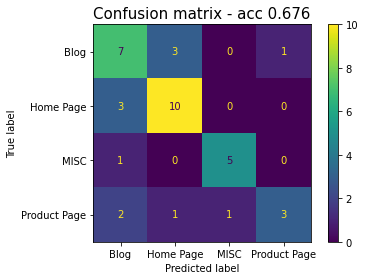

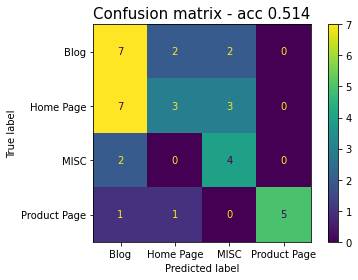

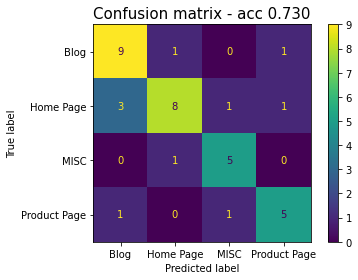

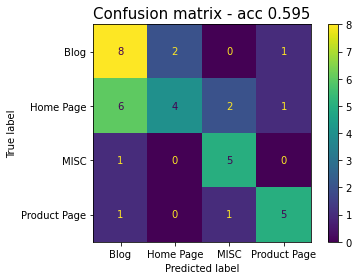

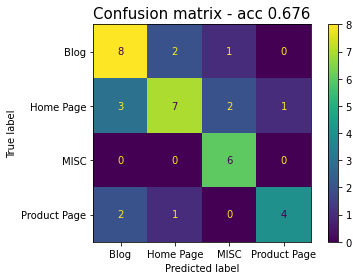

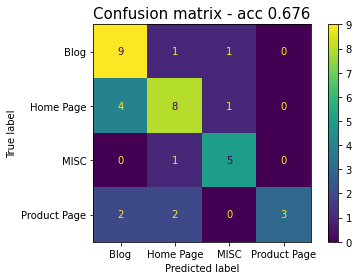

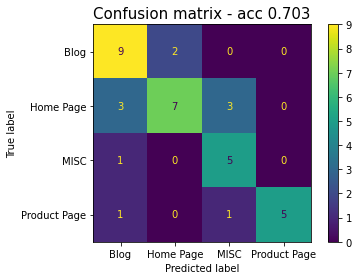

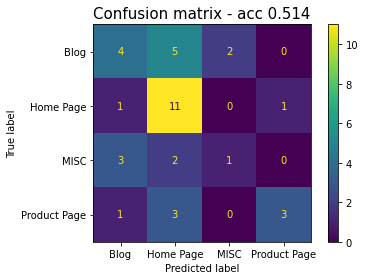

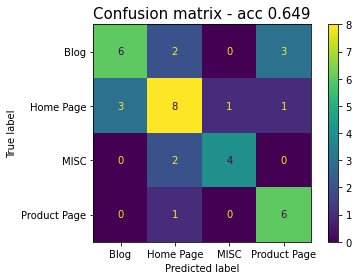

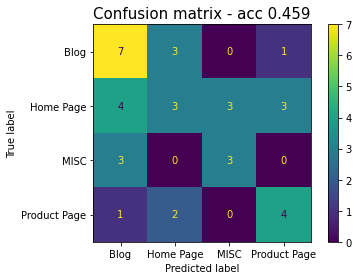

In [43]:
# with stop words from NLTK
# playing with different random states:
for i in range(20):
  X_train_transformed, X_test_transformed, y_train, y_test, vectorizer = preprocessing(y, title_and_summary, maximum_classes=4, 
                                                                                      test_size=0.2, random_state=i, vectorizer='tfidf', stop_words=STOPWORDS)

  clf = fit_model(KNeighborsClassifier(n_neighbors=6), 
                  X_train_transformed, 
                  y_train)

  y_pred = predict(clf, X_test_transformed)

  print_confusion_matrix(y_test, y_pred)

### Continuation

In [ ]:
t

In [ ]:
# # until row 281
# clf = fit_model(model=SVC(C=1,
#                           class_weight='balanced', 
#                           random_state=0), 
#                 X_train=X_train_transformed, 
#                 y_train=y_train)

# y_pred = predict(clf, X_test=X_test_transformed)

# get_accuracy(y_test, y_pred)

In [ ]:
# # until row 295
# clf = fit_model(model=SVC(C=1,
#                           class_weight='balanced', 
#                           random_state=0), 
#                 X_train=X_train_transformed, 
#                 y_train=y_train)

# y_pred = predict(clf, X_test=X_test_transformed)

# get_accuracy(y_test, y_pred)

In [ ]:
# until row 281
def get_best_clf(clfs, X_train, X_test, y_train, y_test):
    results = []
    best_clf = None
    best_clf_name = None
    best_accuracy = 0

    for clf_name, clf in clfs:
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test) # accuracy score
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_clf = clf
            best_clf_name = clf_name

        results.append({'clf': clf_name,
                        'accuracy': acc})
        
    print(pd.DataFrame(results).set_index('clf'))
    return best_clf, best_clf_name, best_accuracy

In [ ]:
# until row 295
clfs = [
    ('LogisticRegression', LogisticRegression(max_iter=4000,
                                              random_state=0)), 
    ('RandomForest', RandomForestClassifier(max_depth=18,
                                            n_estimators=75,
                                            random_state=0)), 
    ('KNN 5', KNeighborsClassifier(n_neighbors=5)),
    ('SVM C1', SVC(C=1,
                   class_weight='balanced', 
                   random_state=0), ),
    ('MultinomialNB', MultinomialNB())
]

# clf, clf_name, val_acc = get_best_clf(clfs, X_train, X_test, y_train, y_test) # To use when I have more data for validation set
# print(f'Best classifier: {clf_name}, validation accuracy: {val_acc:.3f}, '
#       f'test accuracy: {clf.score(X_test, y_test):.3f}')

clf, clf_name, test_acc = get_best_clf(clfs, X_train_transformed, X_test_transformed, y_train, y_test)
print(f'Best classifier: {clf_name}, test accuracy: {test_acc:.3f}')

In [ ]:
def print_search_results(est, X_test, y_test):
    print('Best parameters set found on validation set:', est.best_params_)
    print(f'Best validation score: {est.best_score_:.3f}')

    means = est.cv_results_['mean_test_score']
    stds = est.cv_results_['std_test_score']
    params_all = est.cv_results_['params']
    print('\nScores on validation set:')
    for mean_score, std_score, params in zip(means, stds, params_all):
        print(f'{mean_score:.3f} (+/-{(std_score * 2):.3f}) for {params}')

    print("\nDetailed classification report:")
    print("The model is trained on the full train set.")
    print("The scores are computed on the full test set.")
    y_pred = est.predict(X_test)
    print(classification_report(y_test, y_pred))

In [ ]:
# def grid_search_knn(X_train, y_train): # To use when I have more data for cross validation (cv)
#   metric = 'accuracy'

#   params_dict_knn = [{
#       'metric': ['minkowski', 'euclidean'], 
#       'n_neighbors': [4, 5, 6, 7], 
#       'weights': ['uniform', 'distance'],
#       'algorithm':['auto', 'ball_tree']}]

#   print(f'KNN Tuning hyper-parameters for {metric}')

#   clf_knn = GridSearchCV(KNeighborsClassifier(), 
#                         params_dict_knn, 
#                         scoring=metric, 
#                         cv=5, 
#                         verbose=10,
#                         n_jobs=-1)

#   return clf_knn.fit(X_train, y_train)

# clf_knn = grid_search_knn(X_train_transformed, y_train)
# print_search_results(clf_knn, X_test_transformed, y_test)